# Avance 1 - Sistema de Recomendación

- Matthias Sibrian Illescas A01794249 
- Johan Andrés Castro Gómez A01793556 
- Luis Miguel González Gutiérrez A01794779 

En este notebook se presenta el primer avance del sistema de recomendación. El notebook está dividido en cuatro secciones principales:

1. **Librerías**: Importación de las librerías necesarias.
2. **Lectura de datos**: Carga y preprocesamiento de los datos.
3. **Exploración de datos**: Análisis exploratorio para entender las características de los datos.
4. **Sistema de recomendación base**: Implementación de un sistema de recomendación básico.

### Librerias

In [53]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from transformers import pipeline, AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

### Lectura de datos

In [2]:
df = pd.read_csv('Datos/RAW_interactions.csv')
df

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [39]:
df['review'] = df['review'].astype(str)

### Exploración de datos

In [42]:
print('Número de usuarios:',len(df['user_id'].unique()), '\nNúmero de recetas:', len(df['recipe_id'].unique()))

Número de usuarios: 226570 
Número de recetas: 231637


In [3]:
print(df.isnull().sum())

user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64


In [4]:
(df.isnull().sum()[-1]/len(df))*100

/var/folders/tl/8p6q8vp1621_qbt9h5tg1tlh0000gn/T/ipykernel_82434/1810522486.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df.isnull().sum()[-1]/len(df))*100


0.014924490028409516

Ninguna de las columnas tiene datos nulos, a excepción de la columna "reviews". Sin embargo, el porcentaje de valores nulos en esta columna es de solo 0.015%.

In [5]:
reviews_por_usuario = df['user_id'].value_counts()

In [6]:
reviews_por_usuario

user_id
424680        7671
37449         5603
383346        4628
169430        4076
128473        3917
              ... 
244983           1
139446           1
495446           1
113469           1
2001868099       1
Name: count, Length: 226570, dtype: int64

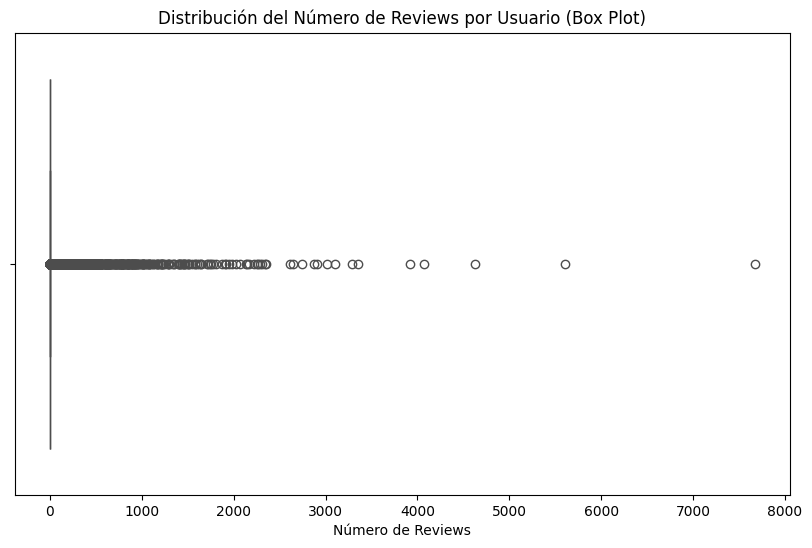

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=reviews_por_usuario, color='orange')
plt.title('Distribución del Número de Reviews por Usuario (Box Plot)')
plt.xlabel('Número de Reviews')
plt.show()

Existen usuarios con un número inusual de reviews. Es necesario determinar si estos valores son correctos o si forman parte de datos erróneos.


In [8]:
percentil_98 = reviews_por_usuario.quantile(0.98)
percentil_98

30.0

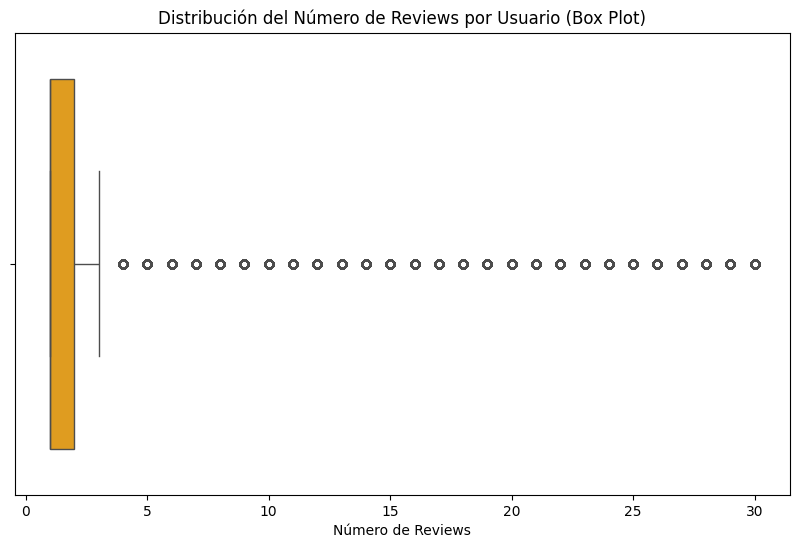

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=reviews_por_usuario[reviews_por_usuario<=percentil_98], color='orange')
plt.title('Distribución del Número de Reviews por Usuario (Box Plot)')
plt.xlabel('Número de Reviews')
plt.show()

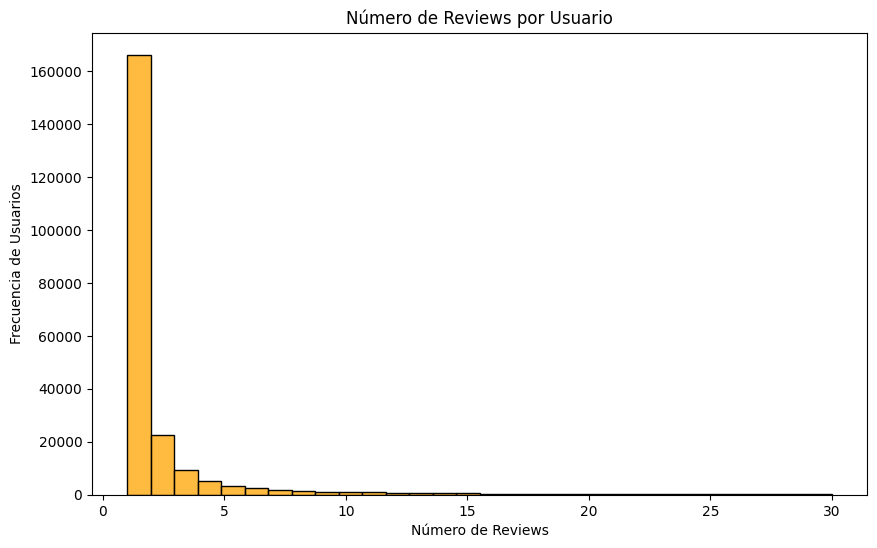

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(reviews_por_usuario[reviews_por_usuario<=percentil_98], kde=False, bins=30, color='orange')
plt.title('Número de Reviews por Usuario')
plt.xlabel('Número de Reviews')
plt.ylabel('Frecuencia de Usuarios')
plt.show()

In [11]:
print(reviews_por_usuario.value_counts().head(30))

count
1     166256
2      22738
3       9346
4       5144
5       3421
6       2566
7       1937
8       1461
9       1215
10      1040
11       842
12       755
13       636
14       552
15       503
16       435
17       366
18       345
19       325
20       298
22       269
21       260
23       246
25       195
26       192
24       185
27       171
29       167
28       157
30       143
Name: count, dtype: int64


De esta primera sección de la exploración de datos, podemos observar que hay un pequeño conjunto de usuarios con un número inusualmente grande de reviews. Además, la mayoría de los usuarios tienen solo un review. Esto es importante al plantear la estrategia del sistema de recomendación final, ya que no solo se debe basar en buscar usuarios similares, sino también en aprovechar la meta información de las recetas para recomendar recetas similares.

/var/folders/tl/8p6q8vp1621_qbt9h5tg1tlh0000gn/T/ipykernel_82434/3295980520.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


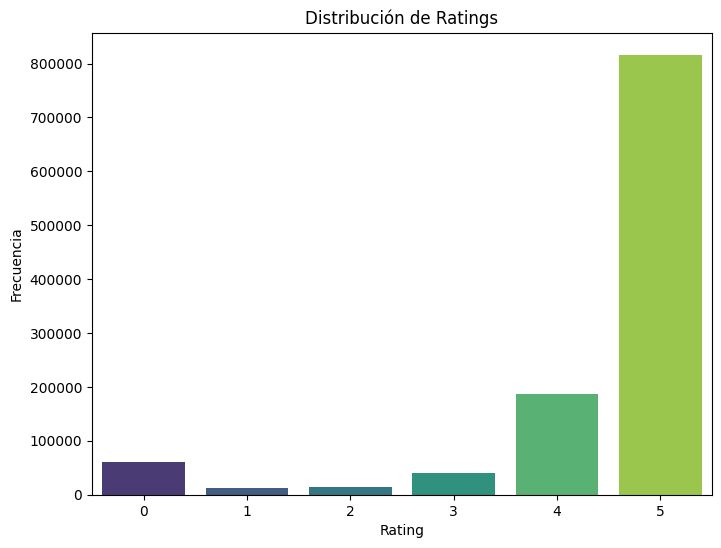

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()


A partir del análisis de la distribución de ratings, se pueden extraer varias conclusiones importantes. La mayoría de las calificaciones son altas, especialmente la calificación de 5, que es la más frecuente, indicando una alta satisfacción de los usuarios con las recetas. Las calificaciones bajas (0, 1, 2 y 3) son significativamente menos frecuentes, sugiriendo que pocas personas tienen experiencias muy negativas. La distribución de las calificaciones está sesgada hacia la derecha, con una fuerte acumulación de calificaciones positivas, lo que podría reflejar una tendencia a dar calificaciones altas o la calidad de las recetas en el sitio. La calificación de 4 también es popular, aunque menos que la de 5. Esta distribución sugiere una satisfacción general alta con las recetas, pero se recomienda realizar un análisis cualitativo de los comentarios para entender mejor las razones detrás de las calificaciones.


In [14]:
todas_reviews = ' '.join(df['review'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(todas_reviews)


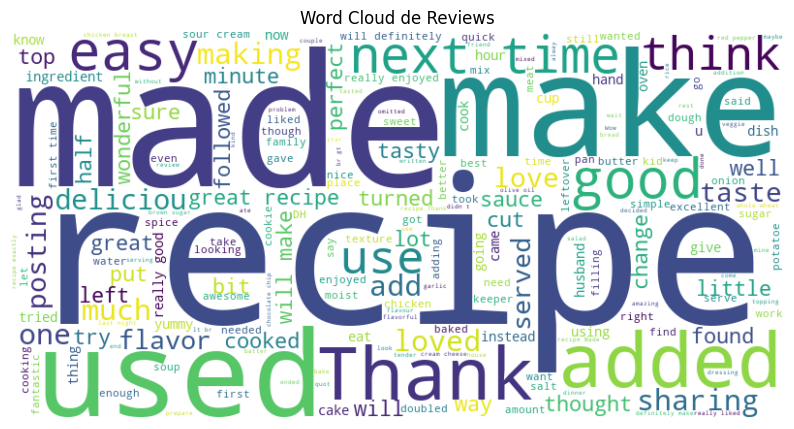

In [15]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud de Reviews')
plt.show()

In [45]:
tamaños = [len(df['review'][i][:2000]) for i in range(0,len(df['review']))]

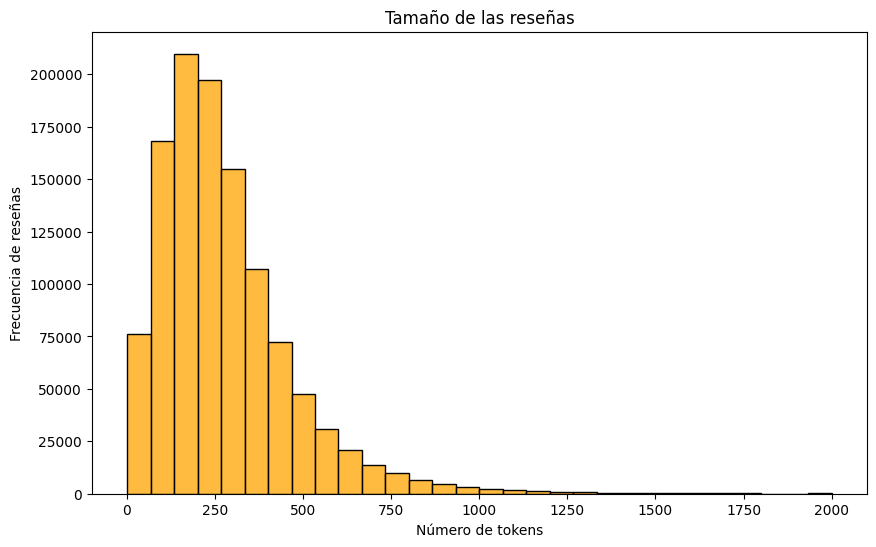

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(tamaños, kde=False, bins=30, color='orange')
plt.title('Tamaño de las reseñas')
plt.xlabel('Número de tokens')
plt.ylabel('Frecuencia de reseñas')
plt.show()

In [49]:
sentiment_analyzer = pipeline("sentiment-analysis")

df_sample = df.sample(n=2000, replace=True, random_state=42)

def analizar_sentimiento(resena):
    resultado = sentiment_analyzer(resena[:512])[0]
    return pd.Series([resultado['label'], resultado['score']])

df_sample[['sentimiento', 'score']] = df_sample['review'].apply(analizar_sentimiento)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


/var/folders/tl/8p6q8vp1621_qbt9h5tg1tlh0000gn/T/ipykernel_82434/3409447299.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_sentimientos.index, y=conteo_sentimientos.values, palette='viridis')


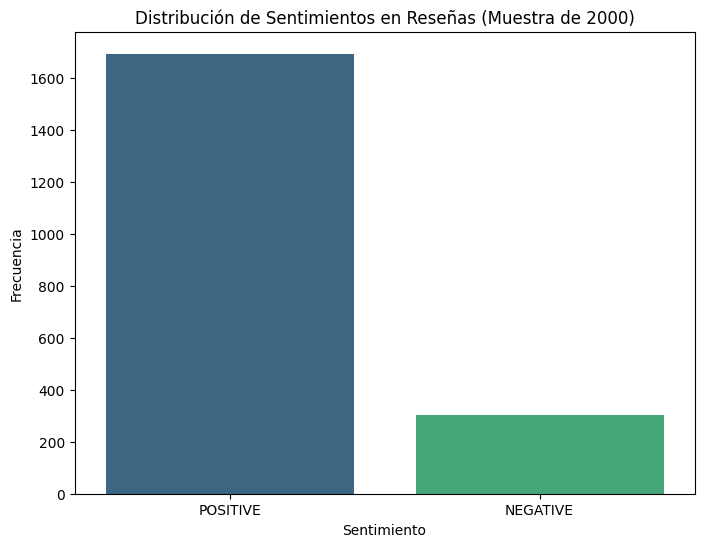

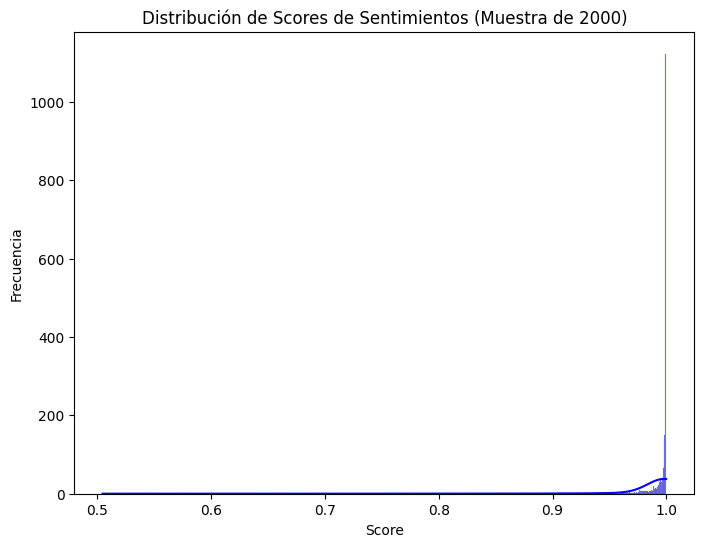

In [50]:
conteo_sentimientos = df_sample['sentimiento'].value_counts()

# Visualizar la distribución de sentimientos
plt.figure(figsize=(8, 6))
sns.barplot(x=conteo_sentimientos.index, y=conteo_sentimientos.values, palette='viridis')
plt.title('Distribución de Sentimientos en Reseñas (Muestra de 2000)')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar la distribución de los scores
plt.figure(figsize=(8, 6))
sns.histplot(df_sample['score'], kde=True, color='blue')
plt.title('Distribución de Scores de Sentimientos (Muestra de 2000)')
plt.xlabel('Score')
plt.ylabel('Frecuencia')
plt.show()

### Sistema de recomendación base

In [51]:
# Mapear los ID de usuarios a índices secuenciales
usuario_ids = df['user_id'].unique()
mapa_usuario_ids = {id: idx for idx, id in enumerate(usuario_ids)}
df['usuario_idx'] = df['user_id'].map(mapa_usuario_ids)

# Mapear los ID de recetas a índices secuenciales
receta_ids = df['recipe_id'].unique()
mapa_receta_ids = {id: idx for idx, id in enumerate(receta_ids)}
df['receta_idx'] = df['recipe_id'].map(mapa_receta_ids)

print("DataFrame con índices mapeados:")
print(df)

DataFrame con índices mapeados:
            user_id  recipe_id        date  rating  \
0             38094      40893  2003-02-17       4   
1           1293707      40893  2011-12-21       5   
2              8937      44394  2002-12-01       4   
3            126440      85009  2010-02-27       5   
4             57222      85009  2011-10-01       5   
...             ...        ...         ...     ...   
1132362      116593      72730  2003-12-09       0   
1132363      583662     386618  2009-09-29       5   
1132364      157126      78003  2008-06-23       5   
1132365       53932      78003  2009-01-11       4   
1132366  2001868099      78003  2017-12-18       5   

                                                    review  \
0        Great with a salad. Cooked on top of stove for...   
1        So simple, so delicious! Great for chilly fall...   
2        This worked very well and is EASY.  I used not...   
3        I made the Mexican topping and took it to bunk...   
4        

In [55]:
# Crear una matriz dispersa de puntuaciones de usuarios y recetas
matriz_usuario_receta = csr_matrix(
    (df['rating'], (df['usuario_idx'], df['receta_idx']))
)

print("Matriz de puntuaciones dispersa:")
print(matriz_usuario_receta)


Matriz de puntuaciones dispersa:
  (0, 0)	4
  (0, 1485)	5
  (0, 14326)	5
  (0, 21140)	5
  (0, 25053)	5
  (0, 31165)	4
  (0, 32302)	5
  (0, 35705)	5
  (0, 35795)	5
  (0, 37163)	5
  (0, 41982)	5
  (0, 42616)	5
  (0, 60267)	4
  (0, 75417)	5
  (0, 85058)	5
  (0, 90931)	5
  (0, 92536)	5
  (0, 108803)	5
  (0, 110276)	5
  (0, 115716)	5
  (0, 116584)	5
  (0, 120695)	5
  (0, 128764)	4
  (0, 130205)	5
  (0, 131128)	5
  :	:
  (226545, 231597)	2
  (226546, 231604)	1
  (226547, 231604)	0
  (226548, 231604)	4
  (226549, 231577)	5
  (226550, 231577)	5
  (226551, 231587)	0
  (226552, 231587)	0
  (226553, 231587)	5
  (226554, 231541)	5
  (226555, 231541)	5
  (226556, 231581)	1
  (226557, 231581)	5
  (226558, 231564)	3
  (226559, 231564)	5
  (226560, 231623)	0
  (226561, 231624)	0
  (226562, 231624)	5
  (226563, 231512)	5
  (226564, 231512)	5
  (226565, 231564)	1
  (226566, 231564)	5
  (226567, 231564)	5
  (226568, 231635)	0
  (226569, 231618)	5


In [56]:
similitud_usuarios = cosine_similarity(matriz_usuario_receta, dense_output=False)

print("Matriz de similitud de usuarios dispersa:")
print(similitud_usuarios)

Matriz de similitud de usuarios dispersa:
  (0, 704)	0.003259534614554419
  (0, 223253)	0.17450120318994403
  (0, 156)	0.0034372747979382026
  (0, 222420)	0.17450120318994403
  (0, 13972)	0.036449461721750134
  (0, 13628)	0.045150177980800364
  (0, 6414)	0.01337489243100257
  (0, 4221)	0.02271812160814228
  (0, 2788)	0.014376976759039532
  (0, 2532)	0.01650060418398368
  (0, 2185)	0.018687025718794492
  (0, 1357)	0.02677356307489673
  (0, 1178)	0.015701089322590005
  (0, 214966)	0.17450120318994403
  (0, 214965)	0.17450120318994403
  (0, 214964)	0.17450120318994403
  (0, 214937)	0.17450120318994403
  (0, 214936)	0.17450120318994403
  (0, 214935)	0.17450120318994403
  (0, 99817)	0.12339098410082101
  (0, 99730)	0.07123981788618185
  (0, 91355)	0.07537303983087498
  (0, 75483)	0.06595525530316328
  (0, 63754)	0.05114720846982612
  (0, 37048)	0.06771960029613133
  :	:
  (226566, 674)	0.023753036128970253
  (226566, 348)	0.09336421087165889
  (226567, 226567)	1.0
  (226567, 226566)	1.0
  (

In [57]:
def obtener_recomendaciones(id_usuario, df, matriz_usuario_receta, similitud_usuarios, num_recomendaciones=5):
    idx_usuario = df[df['user_id'] == id_usuario]['usuario_idx'].iloc[0]
    # Obtener las puntuaciones del usuario objetivo
    calificaciones_usuario = matriz_usuario_receta[idx_usuario, :].toarray().flatten()
    
    # Calcular las puntuaciones ponderadas basadas en la similitud
    usuarios_similares = similitud_usuarios[idx_usuario].toarray().flatten()
    suma_ponderada = matriz_usuario_receta.T.dot(usuarios_similares)
    
    # Normalizar por la suma de las similitudes
    suma_similitudes = usuarios_similares.sum()
    calificaciones_ponderadas = suma_ponderada / suma_similitudes
    
    # Crear un DataFrame con las puntuaciones
    recomendaciones = pd.Series(calificaciones_ponderadas, index=df['receta_idx'].unique()).sort_values(ascending=False)
    
    # Filtrar recetas ya calificadas por el usuario
    ya_calificadas = calificaciones_usuario.nonzero()[0]
    recomendaciones = recomendaciones[~recomendaciones.index.isin(ya_calificadas)]
    
    return recomendaciones.head(num_recomendaciones)

# Obtener recomendaciones para un usuario específico
id_usuario = 38094
recomendaciones = obtener_recomendaciones(id_usuario, df, matriz_usuario_receta, similitud_usuarios)

print(f"Recomendaciones para el usuario {id_usuario}:")
print(recomendaciones)


Recomendaciones para el usuario 38094:
170922    0.201682
129280    0.180556
174671    0.177200
164826    0.165206
47822     0.147212
dtype: float64
